## Problem Statement
**What qualities of crude oil lead to pipeline accidents?**

Pipelines are generally regarded as a safe way to transport fuel, a far better alternative to tanker trucks or freight trains. But when a pipeline does fail, the consequences can be catastrophic; since 1986, pipeline accidents have killed more than 500 people, injured over 4,000 and cost nearly seven billion dollars in property damage. 

Using any resources available to you, can you determine *what phyisical chemical properties* of crude oil could be responsible for pipeline accidents?

---


### Scoping and Assumptions

For scope, I am going to focus on pipelines within Canada, this is both due to the relevance of the problem and due to the data availability. In addition, I am more familiar with the political and business landscape of Canada, which is important to consider for the second part of the question.

To tackle this question, first I will make some qualifying assumptions:

- I am going to assume all Canadian Crude has similar enough chemistry to the Western Canadian Select benchmark values be considered as one product when analysing pipeline accidents
- I am going to assume that the differences in pipeline accident trends are primarily influenced by the properties of the material in conjunction with external factors (operator, location, weather conditions, etc.)
- I am going to assume that all reporting data is accurate, and that reporting is standardized between operators and sites, so as to be comparable

### Backgrounder - What is a pipeline accident?

To answer why pipeline accidents happen, first we have to figure out what we mean when we say "accident". I will start by analysing the [pipeline incident dataset](https://open.canada.ca/data/en/dataset/7dffedc4-23fa-440c-a36d-adf5a6cc09f1) provided by the National Energy Board through the Canada Energy Regulator. This will provide us of an idea of what kind of incidents occurred during the reporting period (2008-2025). Given that this is a dataset of all pipelines, not just crude oil, we might also get some insight into how or why incidents concerning crude oil are different than other petrochemicals.

The CER defines an incident as any one of the following occurences:
- (a) the death or serious injury to a person;
- (b) a significant adverse effect on the environment;
- (c) an unintended fire or explosion;
- (d) an unintended or uncontained release of low vapour pressure (LVP) hydrocarbons in excess of 1.5 m³;
- (e) an unintended or uncontrolled release of gas or high vapour pressure (HVP) hydrocarbons;
- (f) the operation of a pipeline beyond its design limits as determined under CSA Z662 or CSA Z276 or any operating limits imposed by the Board.

With this in mind let's take a look at the dataset.

In [1]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium as fm
from scipy.stats import chi2_contingency, spearmanr
from utils.helper_functions import compute_year_correlation, sum_word_frequencies
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
#OS agnostic file path for importing the data
file_path = os.path.join('data','in','pipeline-incidents-comprehensive-data.csv')

df_raw = pd.read_csv(filepath_or_buffer= file_path,encoding='utf-8', encoding_errors='ignore')

In [3]:
#start quantifying missing data for EDA
missing = df_raw.isnull().sum()
missing[missing>0]

Nearest Populated Centre                                                             2
Occurrence Date and Time                                                           458
Discovered Date and Time                                                             4
Detailed what happened                                                              27
Detailed why it happened                                                            28
                                                                                  ... 
Repair date                                                                       1743
Most recent inspection date for the failed equipment or component                 1626
Type of most recent inspection                                                    1627
Date of the most recent maintenance work for the failed equipment or component    1714
Most recent maintenance Type                                                      1668
Length: 66, dtype: int64

In [ ]:
#do some data cleaning in the substances categories, this is not exactly perfect but good for a rough screen
df_raw['Substance carried'] = df_raw['Substance carried'].str.replace(r'.*Crude Oil.*', 'Crude Oil', regex=True)
df_raw['Substance carried'] = df_raw['Substance carried'].str.replace(r'.*Natural Gas.*', 'Natural Gas', regex=True)
df_raw['Substance carried'] = df_raw['Substance carried'].str.replace(r'^(?!.*(Crude Oil|Natural Gas)).*$', 'Other', regex=True)


#while there are other ways to interpolate data - for this project we are only going to look at pipelines where we know what they are carrying for sure
df = df_raw[df_raw['Substance carried'].notnull()].copy()

<Axes: title={'center': 'Pipeline Incidents (2008-2025)'}, xlabel='Number of Incidents', ylabel='Substance carried'>

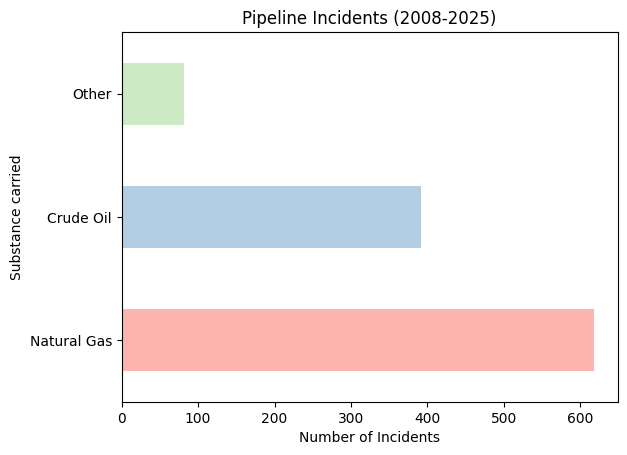

In [5]:
#plot distribution of pipeline incidents by type of substance carried
df['Substance carried'].value_counts().plot(xlabel='Number of Incidents',kind='barh', facecolor=['#fbb4ae','#b3cde3','#ccebc5'], title = 'Pipeline Incidents (2008-2025)')

After some data cleaning we observe that over the last ~20 years the majority of pipeline related incidents have been from pipelines carrying natural gas, while about 35% of the incidents have been in pipelines transporting crude oil. 

In [6]:
incident_counts = df['Incident Types'].value_counts(dropna=False)
incident_counts

Incident Types
Release of Substance                                   339
Operation Beyond Design Limits                         321
Fire                                                   260
Serious Injury (CER)                                    84
Adverse Environmental Effects                           59
Explosion                                               11
Fire, Release of Substance                               4
Explosion, Fire, Release of Substance                    3
Fatality                                                 3
Release of Substance, Adverse Environmental Effects      3
Explosion, Fire                                          2
Serious Injury (CER), Fire                               1
Name: count, dtype: int64

In [7]:
#drop some of the uncommon incidents to make results a bit more interpretable
valid_incidents = incident_counts[incident_counts>=5].index
df_incidents = df[df['Incident Types'].isin(valid_incidents)].copy()

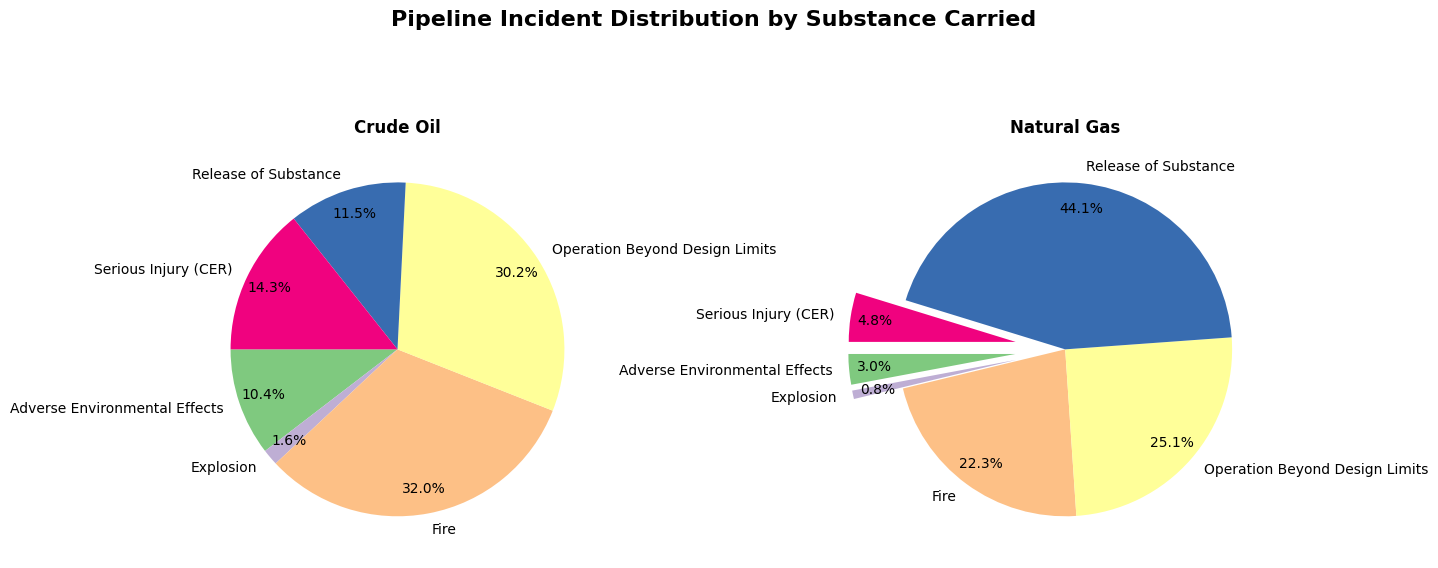

In [8]:
#compare the incident frequency by substance carried
colours = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']

pivot_df = pd.crosstab(df_incidents['Substance carried'], df_incidents['Incident Types'])


fig, axes = plt.subplots(1, 2, figsize=(14, 7))

#pie chart for crude oil
pivot_df.loc['Crude Oil'].plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=180, colors=colours,labeldistance=1.1, pctdistance=0.85)
axes[0].set_title('Crude Oil',fontweight='bold')
axes[0].set_ylabel('')

#pie chart for natural gas
pivot_df.loc['Natural Gas'].plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=180, colors=colours,labeldistance=1.1, pctdistance=0.85, explode = [0.3,0.3,0,0,0,0.3])
axes[1].set_title('Natural Gas',fontweight='bold')
axes[1].set_ylabel('')

fig.suptitle('Pipeline Incident Distribution by Substance Carried',fontsize=16, fontweight = 'bold')
fig.subplots_adjust(wspace=0.6)


plt.show()

In [9]:
pivot_df_other = pd.crosstab(df_incidents['Incident Types'],df_incidents['Substance carried'])
pivot_df_other.drop(columns = 'Other', inplace=True)
pivot_df_other

Substance carried,Crude Oil,Natural Gas
Incident Types,,
Adverse Environmental Effects,40,18
Explosion,6,5
Fire,123,136
Operation Beyond Design Limits,116,153
Release of Substance,44,269
Serious Injury (CER),55,29


So, considering the breakdown of pipeline incidents, the majority of incidents are either Operation Beyond Design Limits or Fire. To test that the distribution of accidents is related to the type of substance in the pipeline, we will perform a simple chi squared test, where the null hypothesis of a chi-squared test is that there is no association between the material carried in the pipeline, and the incident types that occur.

In [10]:
#test if there is a significant difference between carrying crude oil in a pipeline in terms of accidents and carrying natural gas

#perform chi-square test
chi2, p, dof, expected = chi2_contingency(pivot_df_other)

print(f"chi-square statistic: {chi2}")
print(f"p value: {p}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:")
print(expected)


# fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# #plot the observed data
# sns.heatmap(pivot_df_other, annot=True, cmap="Blues", ax=ax[0])
# ax[0].set_title("Observed Frequencies")

# #plot expected frequencies from chi-squared test
# sns.heatmap(expected, annot=True, cmap="Blues", ax=ax[1])
# ax[1].set_title("Expected Frequencies")

# plt.tight_layout()
# plt.show()


chi-square statistic: 139.8093642921533
p value: 1.9642225873981928e-28
degrees of freedom: 5
expected frequencies:
[[ 22.40643863  35.59356137]
 [  4.24949698   6.75050302]
 [100.05633803 158.94366197]
 [103.9195171  165.0804829 ]
 [120.91750503 192.08249497]
 [ 32.45070423  51.54929577]]


The p value for the test is much less than 0.05, so we can safely reject the null hypothesis. In other words, there is a dependency between the kind of pipeline incident, and the material that the pipeline is carrying! This, in part, validates our second assumption.


---

### Cause analysis for pipeline incidents

With some correlation established between the type of product and the distribution of incidents, we will now move forward to understanding what is the cause of each of these incident types and how to correlate them to the materials properties of crude oil. To limit the scope this exercise we will focus we will focus on the three incident types that make up the majority of crude oil pipeline incidents and from their title appear to be the most related to the physicochemical properties of crude oil: **Operation Beyond Design Limits, Fire, and Release of Substance.**


#### 1A. Operation Beyond Design Limits

First let's look into the most common incident for crude oil pipelines

In [11]:
#parse the reporting for what conditions caused the incident
crude_oil_df = df[df['Substance carried']=='Crude Oil'].copy()
crude_oil_df[crude_oil_df['Incident Types']=='Operation Beyond Design Limits']['Conditions that resulted in the operation beyond  limits'].value_counts()


Conditions that resulted in the operation beyond  limits
Over Pressure                                52
Exposed Pipe                                 42
Exposure in a Waterbody                      14
Overpressure - Maximum Operating Pressure     5
Slope Movements                               2
Exposure on Land                              1
Name: count, dtype: int64

While several of these cases are likely independent of the chemical properties of the substance carried in the pipeline (e.g. exposed pipe or exposure in a waterbody), over pressure could potentially be related to the chemical properties of crude oil. So, what causes Over pressure in crude oil pipelines?


Overpressure can be caused by several factors, but one of the most common causes is pipeline **obstruction by the debris or solids**, such as the formation of **crude oil hydrates** (when reacted with water), and other generally soluble components crystalizing out of solution. Typically, the conditions that are necessary for this type of formation are:
1. the presence of water
2. high pressure
3. low temperature

[source](https://pmc.ncbi.nlm.nih.gov/articles/PMC9366985)

Given that all pipelines operate as pressurized systems (to transport fluid at long distances) and it is nearly impossible to remove all water from industrial processes, the last variable to consider is the temperature.

If hydrate formation is causing pipeline over pressure, we would expect a seasonal correlation in the reporting dates


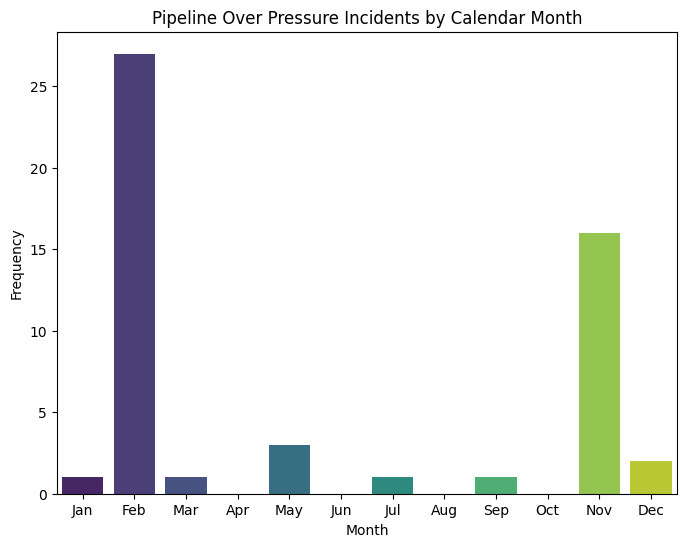

In [12]:
reported_dates = crude_oil_df[(crude_oil_df['Incident Types']=='Operation Beyond Design Limits')&(crude_oil_df['Conditions that resulted in the operation beyond  limits']=='Over Pressure')]['Reported Date'].copy()

datetime_dates = pd.to_datetime(reported_dates, format = '%m/%d/%Y')
months = datetime_dates.dt.month
month_counts = months.value_counts().sort_index()
month_counts = month_counts.reindex(range(1, 13), fill_value=0)


plt.figure(figsize=(8, 6))
sns.barplot(x=month_counts.index, y=month_counts.values, palette="viridis")
plt.title('Pipeline Over Pressure Incidents by Calendar Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


The majority of the over pressure incidents do coincide with winter months, especially those with more highly variable daily temperatures. Checking the historical weather data across some of the outliers, July 30, 2016, and May 7, 2017 were both days that experienced uncharacteristically cold periods where the ambient temperature dropped below 15 degrees Celsuis, which are conditions that enable hydrate formation. 

Taken together we can attribute crude oil hydrate formation to the majority of over pressure incidents.

#### 1B. Potential solutions to limit hydrate formation and their business impacts

<ins>Policy Options and Business Impact</ins>

Three potential policy options to limit or reduce crude oil pipeline over pressure incidents are:

1. Implement or increase minimum concentration for hydrate inhibiting additives (e.g. methanol).
2. Implement or increase the insulation requirements for pipelines (all the pipelines experiencing over pressure were not insulated).
3. Reduce the maximum operating pressure for crude oil pipelines.


Of all these policy solutions the simplest to implement would be reducing the maximum operating pressure for crude oil carrying pipelines, though this may have some added negatives of reducing the flow rate of the oil through the pipeline, which in turn would increase the minimum temperature for hydrate formation. Because this trade-off is not clear and would be influenced by the parameters of each individual pipeline (based on the geometry of the pipeline) - I would not recommend this solution. In addition, this reduced flow rate would reduce the throughput of a given pipeline, lowering oil output. This lowered output has the potential to reduce the competitiveness of Canadian or North American oil products, as supply gaps could potentially be filled by extraction operations in other countries. That being said, if the supply could not be easily increased then the impact on oil markets would potentially be the increase in oil prices as a function of scarcity - offsetting the immediate revenue reductions that one would expect with lower oil pipeline throughput.

Between policy options 1 and 2, I would suggest **option 1, implementing or increasing the minimum hydrate inhibiting additive concentration**. While option 2 is attractive due to its simplicity and limited increases to operating costs, insulating hundreds and hundreds of kilometers of pipelines is both extremely capital intensive, will require additional operational maintenance, and will make it more challenging to visually inspect pipelines for other signs of wear (such as corrosion). Additional additives to crude oil could easily be injected using existing machinery in pipelines, such as those that are currently used to incorporate drag reducing agents. From a business perspective this would increase the operating costs of crude oil pipelines, thereby reducing the profit per volume, but these operating costs could be offset in two ways. First, by reducing the formation of hydrates, pipelines would remain unobstructed, enabling them to operate at peak throughput for longer periods of time. Second, if methanol were to be used, methanol is a value-added product that is commonly produced as a byproduct of carbon dioxide capture (via the reduction of carbon dioxide to methanol). So, such a system could be paired with carbon capture and sequestration systems which could qualify for government incentives and reduce the carbon tax burden on Canadian pipeline operation.





<ins>Have we gotten better at regulating these properties and how can we measure success?</ins>

To determine if we have improved at regulating hydrate formation that causes overpressure over time, we can look at the correlation between the frequency of overpressure incidents over time. To do this we will compute Spearman's $\rho$ coefficient for the last 10 years of incident data, which will indicate if the number of incidents has reduced over time. Spearman's $\rho$ is a bit more robust than the more popular Pearson's R as it does not assume a linear relationship between variables.


Text(0.5, 1.0, 'Annual Frequency of Pipeline Over Pressure Incidents')

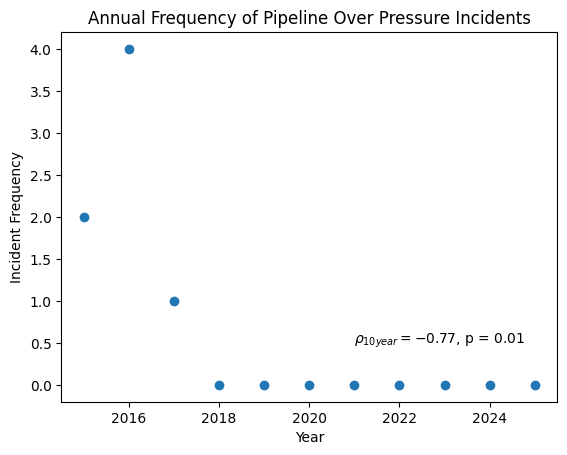

In [13]:
crude_oil_date_counts = datetime_dates.dt.year.value_counts(sort=False).sort_index()

crude_oil_date_counts, rho, p = compute_year_correlation(crude_oil_date_counts,2015,2025)

plt.scatter(x=crude_oil_date_counts.index, y=crude_oil_date_counts.values)

rho_text = r'$\rho_{10year} = %.2f$' % rho + r', p = %.2f' % p

plt.annotate(rho_text, (crude_oil_date_counts.index[-2]-3,crude_oil_date_counts.values[-2]+0.5))
plt.xlabel('Year')
plt.ylabel('Incident Frequency')
plt.title('Annual Frequency of Pipeline Over Pressure Incidents')


After computing Spearman's $\rho$ we can conclude that the number of over pressure incidents in the last 10 years has reduced dramatically (a $\rho$ near -1) and significantly (p < 0.05). We can similarly compute these statistical measures over various time periods to measure the shorter- and longer-term success of a policy intervention.

Some other metrics that could be implemented to measure success on the shorter term are:
1. Daily pipeline flow volume
2. Day over day pressure increase
3. Temperature-Pressure dependence over time

These values could be compared with historical data, where a Student's T test could be employed to measure deviation from historical, and statistically significant changes would indicate the success of an intervention, and the size of the change would indicate the level of success. This could further be tested with Bayesian statistics if we had the treatment applied to one pipeline, and another pipeline that received a null treatment (or no change from historical policy)


#### 2A. Fire

While it is obvious that crude oil is flammable, and regulating this property is key for avoiding fires, let's dig a little deeper to understand why fire is the second most common incident, and why its frequency is higher than expected from the chi-squared analysis earlier.

Text(0.5, 1.0, 'Fire Sources')

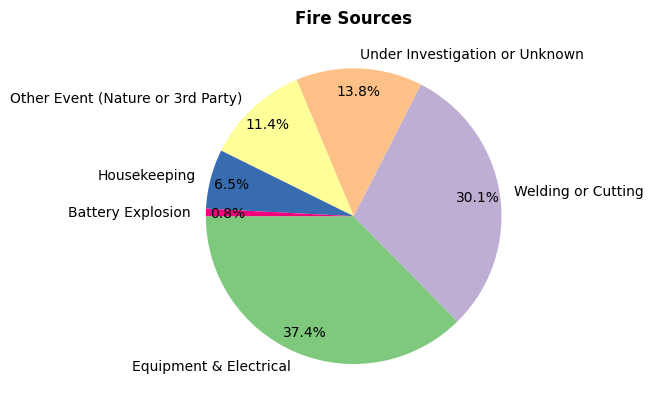

In [14]:
fire_df = crude_oil_df[crude_oil_df['Incident Types']=='Fire'].copy()
counts = fire_df['Source of Fire'].value_counts(dropna=False)

counts.plot(kind='pie', autopct='%1.1f%%', startangle=180, colors=colours,labeldistance=1.1, pctdistance=0.85, ylabel ='')
plt.title('Fire Sources', fontweight='bold')


So, the major sources of fire for crude oil pipelines are to be Equipment & Electrical followed by Welding or Cutting. This makes sense as these operations likely provide sources of ignition in proximity to the flammable crude oil products. Let's try to dig a little deeper.

In [15]:
crosstab = pd.crosstab(fire_df['Source of Fire'],fire_df['Activity being performed at time of incident'],margins=True, margins_name='Sum')
crosstab

Activity being performed at time of incident,Construction,Maintenance,Operation,Sum
Source of Fire,,,,
Battery Explosion,1,0,0,1
Equipment & Electrical,28,10,8,46
Housekeeping,6,2,0,8
Other Event (Nature or 3rd Party),8,3,3,14
Under Investigation or Unknown,15,0,2,17
Welding or Cutting,30,7,0,37
Sum,88,22,13,123


The majority of fire incidents that are reported at pipeline sites are during the construction of the pipeline, prior to operation. Let's narrow down the incidents to consider fire incidents that occur when there is crude oil present.

In [16]:
active_fire_df = fire_df[(fire_df['Activity being performed at time of incident']=='Maintenance')|(fire_df['Activity being performed at time of incident']=='Operation')].copy()
active_fire_df['What happened category'].value_counts()

What happened category
External Interference, Incorrect Operation                       10
External Interference                                            10
Equipment Failure                                                 7
Incorrect Operation                                               5
External Interference, Incorrect Operation, Other Causes          1
Equipment Failure, External Interference                          1
Equipment Failure, External Interference, Incorrect Operation     1
Name: count, dtype: int64

In all cases when there is a fire at a crude oil that is commissioned to operate, the explanation for the cause of the fire is a combination of Equipment Failure, External Interference and/or Incorrect Operation. So let's breakdown what these all mean by drawing on the [CER Glossary of Terms](https://www.cer-rec.gc.ca/en/safety-environment/industry-performance/interactive-pipeline/glossary-terms.html):

1. Equipment Failure: A failure of the pipeline’s equipment components. Examples of equipment include valves, electrical power systems and control systems
2. External Interference: External activities that cause damage to the pipeline or components. Examples include excavation damage and vandalism
3. Incorrect Operation: Typically, personnel fail to follow procedures or use equipment improperly

The commonality between these three incident explanations is actions that cause or may cause damage to a pipeline. From the incident reporting, there is no measurable release of substance in these cases of fire, so what is providing the fuel to enable these fires?

<ins>Volatiles in crude oil and leak metering</ins>

Chemically, crude oil is a blend of various hydrocarbon components and contains components that could be either a liquid or a gas. This is especially true of heavier oils such as shale oil or bituminous oil [source](https://www.s4science.at/wordpress/wp-content/uploads/2018/10/article-why-crude-oil-vapor-pressure-should-be-tested-prior-to-rail-transport.pdf).  These gaseous (high vapour pressure) components are highly flammable, as they readily disperse in air, providing a source of oxygen for combustion. In addition, small imperfection in pipelines can result in pinhole leaks, where the local pressure reduction is enough to enable volatile compounds to boil, and escape from the pipeline. These leak types are extremely difficult to detect as the pressure drop is negligible compared to those provided in the pumping and lifting stations, and the resulting leaks are not easily visible [source](https://www.sciencedirect.com/science/article/pii/S135063071930322X).


In total, the data supports that wear and tear during maintenance and operation of crude oil pipelines can enable superficial leaking that is both challenging to detect and can provide a fuel source that can be ignited by hand tools or electrical equipment.


#### 2B. Potential solutions to volatiles fueled fires and their business impacts

<ins>Policy Options and Business Impact</ins>

Some potential policy options are:
1. Require the use of power source enclosed tools
2. Mandate stop work and inspect after potential damage
3. Require the use of lidar or other imaging tools to find pinhole leaks during pre-work inspection

Of these potential policy solutions, I would recommend a implementing a combination of policy 2 and 3: **Mandate stop work and inspect after potential damage, and require the use of imaging tools to find pinhole leaks during pre-work inspection**. There may be other chemistry specific regulations that could reduce the incidence of fire by reducing or removing volatiles from crude oil and treating those compounds differently, but this would be extremely challenging technically and would greatly increase the operating cost for a supplier. Procedural controls are extremely cost effective to implement and are still reasonably high on the hierarchy of controls that they could be effective in combination with other tools. Equipping maintenance teams with additional imaging equipment would represent an increased capital cost, but this should be offset by capturing these slow leaks that cause loss of product earlier. 

Overall this policy implementation would lead to a reduction in fires which are costly, and cause the operation to run more efficiently in a manner that remains capital efficient.

<ins>Have we gotten better at regulating these properties and how can we measure success?</ins>

To determine if we have improved at regulating fires, we will perform the same operation as in the first section to identify any correlation between the number of incidences over time. 

Text(0.5, 1.0, 'Annual Frequency of Pipeline Fire Incidents')

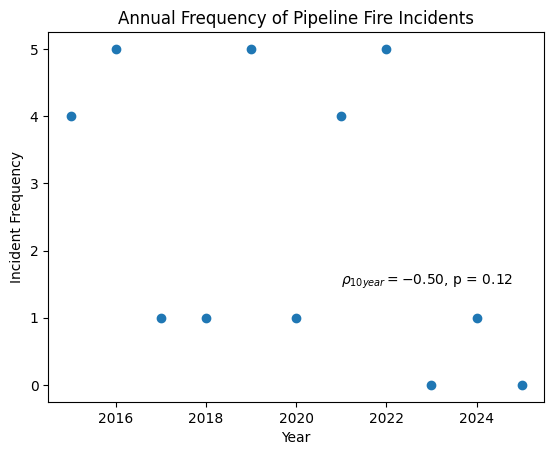

In [17]:
fire_performance = active_fire_df['Year'].value_counts().sort_index()

fire_performance_dates_counts, rho, p = compute_year_correlation(fire_performance,2015,2025)

plt.scatter(x=fire_performance_dates_counts.index, y=fire_performance_dates_counts.values)

rho_text = r'$\rho_{10year} = %.2f$' % rho + r', p = %.2f' % p

plt.annotate(rho_text, (fire_performance_dates_counts.index[-2]-3,fire_performance_dates_counts.values[-2]+0.5))
plt.xlabel('Year')
plt.ylabel('Incident Frequency')
plt.title('Annual Frequency of Pipeline Fire Incidents')



As we did above, analyzing Spearman's $\rho$ indicates that there is a weak negative dependence, but the high p value means that we cannot say with confidence that the rate of fire incidents has decrease over time, indicating that existing interventions for fire suppression or prevention have not been effective at reducing pipeline fires over the last 10 years. As with the example above we can use this metric at various time scale to infer long-term or short-term impact of an given intervention.

Some other metrics that could be used to measure the success of an intervention against pipeline fires on the shorter term are:
1. Rate of fire incidents as a function of number of maintenance interventions
2. Rate of low vapour pressure product loss per km pipeline per day
3. Person-hours lost from fire incidents per quarter

A statistically significant reduction of any of these metrics would mean success, and the magnitude of the reduction would quantify the degree of success. We could further apply the statistical methods discussed in 1B for this problem.

#### 3A. Release of Substance

The final crude oil pipeline incident type we will explore in this report is the release of substance.

<Axes: xlabel='Incident Frequency', ylabel='Cause'>

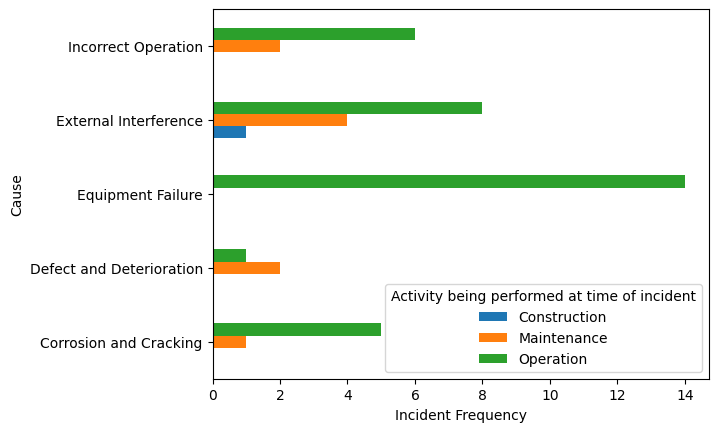

In [18]:
release_df = crude_oil_df[crude_oil_df['Incident Types']=='Release of Substance'].copy()

col1 = release_df['What happened category']
col2 = release_df['Activity being performed at time of incident']

col1 = col1.str.replace(r'Corrosion and Cracking.*', 'Corrosion and Cracking', regex=True)
col1 = col1.str.replace(r'Equipment Failure.*', 'Equipment Failure', regex=True)
col1 = col1.str.replace(r'External Interference.*', 'External Interference', regex=True)
col1 = col1.str.replace(r'Defect and Deterioration.*', 'Defect and Deterioration', regex=True)

release_crosstab = pd.crosstab(col1,col2)
release_crosstab.plot(kind='barh',xlabel='Incident Frequency', ylabel='Cause')

In conjunction with the cause definitions that we discussed in the previous section, External Interference and Equipment Failure can both be attributed to damage caused by either lifetime wear and tear or damage from external sources. Defect and deterioration and corrosion and cracking are very similar, to equipment failure, where the operation of the pipeline over time wears on the mechanical integrity of pipeline components. Taken together we can attribute the majority of incident types (all those in this plot exclusive of Incorrect Operation) to wear or failure or mechanical parts or mechanisms. 

Let's narrow this a little bit further to see what parts of the pipeline fail.

In [19]:
#remove the part before the first comma - this contains general information that is not relevant
release_df['Equipment or component involved']= release_df['Equipment or component involved'].str.split(',', n=1).str[1]

release_df['Equipment or component involved'].value_counts()


Equipment or component involved
Pumping, Pump                                                                                                                                                                                  4
Pipe, Body                                                                                                                                                                                     3
Pumping, Valve                                                                                                                                                                                 3
Pumping, Flange, Gasket/O-ring                                                                                                                                                                 2
Pumping, Valve, Ball                                                                                                                                                                           1
Com

There are many different ways that parts have been documented within the reporting. Let's try to make this a bit more interpretable by doing a bit of (very basic) natural language processing.

In [20]:
#use a simple counting function to determine the most common words in the equipment of components involved category
common_words = sum_word_frequencies(release_df['Equipment or component involved'])

common_words.most_common(10)

[('Pumping', 25),
 ('Valve', 16),
 ('Ball', 11),
 ('Fitting', 9),
 ('please', 7),
 ('Body', 6),
 ('explain', 6),
 ('Pipe', 5),
 ('Other', 5),
 ('Pump', 4)]

It appears the most common parts that fail are the (ball) valves, fittings between pipes, and the pipe body. So, what properties of crude oil might make these components prone to failure?

<ins>Sour Crude, Corrosion and Pipeline Wear</ins>

Western Canadian Select (WCS) crude is an example of sour crude oil. Sour crude contains a reasonable amount of sulfur (as Hydrogen Sulfide), which yields a product that is corrosive. Corrosion in WCS containing pipelines is also facilitated by other impurities that may remain from the pressurized steam extraction process that liberates oil components from the sand in the Canadian oil sands. There impurities, including carbon dioxide and napthenic acid compounds, also contribute to the acidity of the final oil product. The physical properties of the resulting heavy oil are also challenging to handle for mechanical systems as the oils are both very viscous and any remaining sand in the product is abrasive, leading to enhanced wear as the fluid travels through the pipeline and valves. It is this combination of high viscosity, acidity, and abrasiveness that causes the wear in pipeline components that lead to failure, this is especially true for pumps, flanges and the microscopic gaps between pipeline segments. [source 1](https://onepetro.org/NACECORR/proceedings-abstract/CORR97/All-CORR97/113130),  [source 2](https://link.springer.com/article/10.1007/s40735-019-0225-9)


In practice, WCS is further blended with additional condensates and diluents to reduce the acidity to the benchmark 0.93 total acid number (TAN) and lower the viscosity and abrasiveness of the final product.  

#### 3B. Potential solutions to sour crude related corrosion or wear and their business impacts

<ins>Policy Options and Business Impact</ins>

Some potential policy options are:
1. Mandate the use of or increase of corrosion inhibiting compounds
2. Reduce the maximum allowable viscosity for pipeline operations
3. Reduce the maximum allowable contaminant concentrations in pipeline crude products

Of these potential policy options, I would suggest policy 1: **mandate the use of or increase of corrosion inhibiting compounds**. Given that the products in Canadian pipelines are already blends of various components and diluents, it would be relatively easy to implement by introducing an additional chemical or formulation to existing diluent streams. The drawback of this policy would be a slight increase in operating costs, which in turn would increase prices for the operator and potentially cause fluctuations in the overall market prices. Ideally, these risks would be mitigated by reducing the number of pipeline incidents that yield release of product, which in turn would reduce downtime and inspire market confidence. The correct selection of which inhibitors to mandate would be influential in the overall response and would need to be products that are inexpensive and simple to isolate in waste streams that are already produced in a typical WCS refinery. 




<ins>Have we gotten better at regulating these properties and how can we measure success?</ins>

As with the other sections of this project we will conduct our Spearman's $\rho$ correlation on the 10-year window for release of substance incidences. 

Text(0.5, 1.0, 'Annual Frequency of Pipeline Release of Substance Incidents')

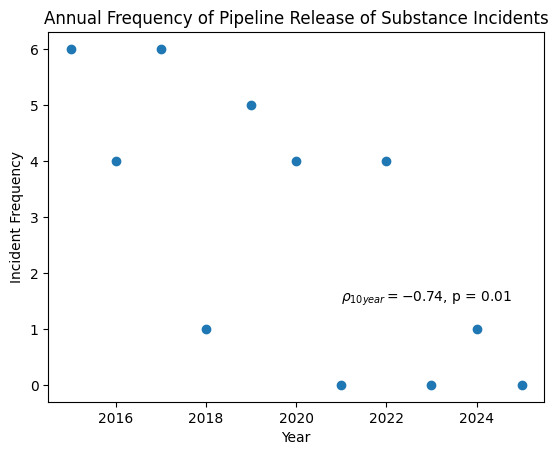

In [21]:
release_performance = release_df['Year'].value_counts().sort_index()

release_performance_dates, rho, p = compute_year_correlation(release_performance,2015,2025)

plt.scatter(x=release_performance_dates.index, y=release_performance_dates.values)

rho_text = r'$\rho_{10year} = %.2f$' % rho + r', p = %.2f' % p

plt.annotate(rho_text, (release_performance_dates.index[-2]-3,release_performance_dates.values[-2]+0.5))
plt.xlabel('Year')
plt.ylabel('Incident Frequency')
plt.title('Annual Frequency of Pipeline Release of Substance Incidents')

Analyzing our 10-year metric indicates that Canadian pipeline incidents that result in release of substance have reduced dramatically and significantly. This indicates that the policies that have been implemented to mitigate these incidents have been effective over the term of analysis.


---

### Summary of Findings

To determine which physical and chemical properties of crude oil could lead to pipeline incidents we analysed a database of pipeline incidents. We made several assumptions on the underlying data, namely that the oil transported in these pipelines was equivalent to Western Canadian Select, that the reports were consistent between operators, and that any trends in incidents were primarily related to the properties of the crude oil. For our scope we limited our analysis to the Canadian pipeline context, for simplicity and due to data availability. 

After analysing the data, we identified the following three incidents classes that were prevalent during the operation or maintenance of a pipeline, these incident classes were:

- Operating Beyond Design Limits
- Fire
- Release of Substance

Diving more deeply into each incident class we were able to relate the most common incident types to the following properties of crude oil:

- Reactivity of Crude Oil with Water and other contaminants to form hydrates
- Evaporation and escape of flammable high vapour pressure blended crude oil hydrocarbons
- Acidity and abrasiveness of WCS-type crude oils

We then suggested several policy interventions and discussed their impacts business impacts, ultimately those that were both the least negatively impactful to the markets and the most likely to address the root cause of accidents were:

- Implement or increase minimum concentration for hydrate inhibiting additives (e.g. methanol)
- Increasing the stringency and adding tools to typical inspection protocols for LVP leaks
- Mandate the use of or increase of corrosion inhibiting compounds

Generally, all these interventions would possess some increasing to operating costs or additional training for employees, which would represent additional business expenses. The theme of these interventions was to leverage existing infrastructure and on-site resources to minimize additional costs, while ensuring a high level of success. The driving idea being that these types of interventions could increase the reliability of pipeline infrastructure, which could then offset the costs associated with these interventions.

In the case of Operating Beyond Design Limits and Release of Substance, the 10-year trend has shown a significant and strong reduction in overall event occurrence, leading us to suggest that our ability to limit these accidents has improved over time. Fire still remains as an incident type that has not been effectively reduced over time and is still a challenge for the industry in the present day.



---




### Appendix

#### Where do pipeline incidents occur?
Let's plot incidents on some mapping tools to see if there is a geographical dependence (this may not render propertly on github depending on your browser settings)

In [22]:
#instantiate map and get center - depending on your browser this may not render outside of a local instance of this notebook
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
pipeline_map = fm.Map(location=map_center, zoom_start=3.5)

#plot incidents on map
for _, row in df[(df['Substance carried']=='Crude Oil')].iterrows():
    fm.Marker([row['Latitude'], row['Longitude']]).add_to(pipeline_map)

display(pipeline_map)

#### Limitations and Caveats

The intention for this work is that the data and analysis is somewhat helpful and interesting to the reader. There are however several limitations with the study that should be considered when interpreting these results. 

First, this analysis is limited to one set of reporting data that spans several decades and many different pipeline operations. This means that the data captured within will be subject to many different underlying regulatory changes that can influence the relationships within the data. For example, advances in crude oil extraction technologies could have changed the chemical composition of the crude oil as time progressed, which as we have shown in our analysis, is influential to the mode of failure of pipeline infrastructure. These types of temporal changes also colour the reporting and the accuracy along with the detail to which the data was captured. As another example, the overwhelming majority of release of substance failures in this dataset were attributed to parts that "had been previously inspected" but the date of the inspection was almost never included, making it hard to verify 1. if the part had been inspected, and 2. how long the part had been in service without maintenance.

Second, while pipeline-ready WCS crude oil does have some range of properties that are somewhat controlled, there is the potential to have lots of variability in the composition of material that is passed through the pipeline. More specifically, while macroscopic properties such as the total acid number, viscosity and sulfur content are controlled, the chemicals that are added to arrive at these controlled values are not. The chemical composition of the added diluent, the quantities of added chemicals, and the addition of other possibly wear or failure inducing chemicals is unknown within the dataset. Accordingly, there may be some chemical contribution to incident rates that would not have been captured in this analysis.

Third, pipelines that carry petrochemicals are not always single product. Operators can leverage plug flow to alternate between different products provided there is some metering or tracking in place to switch between petrochemical products as they arrive at the processing facility. The wear that is caused by changing between different chemical compositions, and their associated properties (viscosity, corrosive potential, undesirable reactions, etc.) is not captured by this dataset.


---
